In [95]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import time
import glob
import random
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
import pandas as pd

# Ensure unique name for TensorBoard logs
NAME = "Tcc_cnn_64_{}".format(int(time.time()))


### Utilizando gpu

In [2]:
# Aplicando na gpu
print(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
    

print(tf.test.is_built_with_cuda())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
Default GPU Device: /device:GPU:0
True


### Carregando arquivos

In [45]:
all_traning_paths = glob.glob('DATASETS/TRAINING/*/*.jpg')
all_val_paths = glob.glob('DATASETS/VALIDATION/*/*.jpg')

DATASETS/TRAINING\WITH-CANCER\1-251.jpg


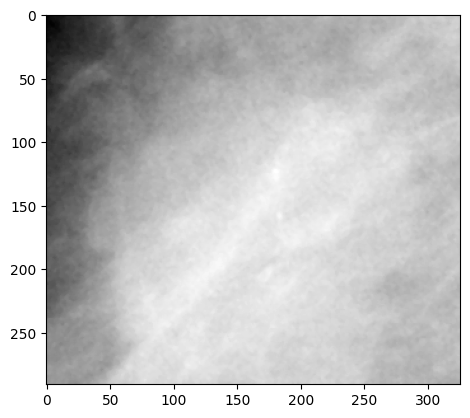

In [78]:
img_path=random.choice(all_traning_paths)
cropped_img = Image.open(img_path)

gray = cropped_img.convert('L')
#median =cv2.blur(np.array(gray), (3, 3))
#aplicando filtro para reduzir ruido
median = cv2.medianBlur(np.array(gray), 3)
print(img_path)
plt.imshow(median, cmap='gray')

# Criando datagens

In [97]:
datagen_resnet = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen_32 = datagen_resnet.flow_from_directory('DATASETS/TRAINING/',
                            target_size=(224,224),
                            class_mode="categorical",
                            batch_size=32 
                            )


validation_gen_32 = datagen_resnet.flow_from_directory('DATASETS/VALIDATION/',
                            target_size=(224,224),
                            class_mode="categorical",
                            batch_size=32
                            )

test_gen = datagen_resnet.flow_from_directory('DATASETS/TESTING/',
                            target_size=(224,224),
                            class_mode="categorical",
                            batch_size=16,
                            
                            )

base_model=ResNet50(include_top=False,
                    input_shape=(224,224,3)
)

for layer in base_model.layers:  # ´Passo para eu não retreinar as camadas do RESNET
    layer.trainable=False
    
    tensorBoard = TensorBoard(log_dir='logs/{}'.format(NAME))

Found 945 images belonging to 2 classes.
Found 146 images belonging to 2 classes.
Found 464 images belonging to 2 classes.


In [6]:
base_model=ResNet50(include_top=False,
                    input_shape=(224,224,3)
)

for layer in base_model.layers:  # ´Passo para eu não retreinar as camadas do RESNET
    layer.trainable=False
    
    tensorBoard = TensorBoard(log_dir='logs/{}'.format(NAME))

## Modelo 3 ADICIONANDO MAIS UMA CADMADA DENSE E UMA DE DROPOUT


In [16]:
modelo3 = Sequential([ base_model,
                     GlobalAveragePooling2D(),
                     Dense(128, activation='relu'),
                     Dropout(0.2),
                     Dense(64, activation='relu'),
                     Dropout(0.2),
                     Dense(2, activation='Softmax')
])

modelo3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                      

In [17]:
modelo3.compile(optimizer=Adam(learning_rate=1e-4),
               loss='categorical_crossentropy',
               metrics=['accuracy']
               )

history3 = modelo3.fit(train_gen, 
           validation_data=validation_gen,
           epochs=15,
           batch_size=16,
           callbacks=[tensorBoard]
        )

Epoch 1/15
60/60 [==============================] - 5s 54ms/step - loss: 0.7300 - accuracy: 0.5608 - val_loss: 0.6764 - val_accuracy: 0.5685
Epoch 2/15
60/60 [==============================] - 3s 43ms/step - loss: 0.6484 - accuracy: 0.6254 - val_loss: 0.6762 - val_accuracy: 0.5890
Epoch 3/15
60/60 [==============================] - 3s 43ms/step - loss: 0.6380 - accuracy: 0.6508 - val_loss: 0.6578 - val_accuracy: 0.6233
Epoch 4/15
60/60 [==============================] - 3s 43ms/step - loss: 0.6046 - accuracy: 0.6783 - val_loss: 0.6514 - val_accuracy: 0.6575
Epoch 5/15
60/60 [==============================] - 3s 43ms/step - loss: 0.5811 - accuracy: 0.6804 - val_loss: 0.6437 - val_accuracy: 0.6644
Epoch 6/15
60/60 [==============================] - 3s 43ms/step - loss: 0.5639 - accuracy: 0.7090 - val_loss: 0.6384 - val_accuracy: 0.6233
Epoch 7/15
60/60 [==============================] - 3s 44ms/step - loss: 0.5478 - accuracy: 0.7344 - val_loss: 0.6268 - val_accuracy: 0.6712
Epoch 8/15
60

In [18]:
pd.DataFrame(history3.history)

,loss,accuracy,val_loss,val_accuracy
0,0.730000,0.560847,0.676440,0.568493
1,0.648435,0.625397,0.676223,0.589041
2,0.638014,0.650794,0.657828,0.623288
3,0.604642,0.678307,0.651429,0.657534
4,0.581074,0.680423,0.643710,0.664384
5,0.563901,0.708995,0.638448,0.623288
6,0.547844,0.734392,0.626763,0.671233
7,0.515010,0.743915,0.617181,0.684932
8,0.511602,0.728042,0.620384,0.671233
9,0.514208,0.739683,0.631126,0.650685


<Axes: >

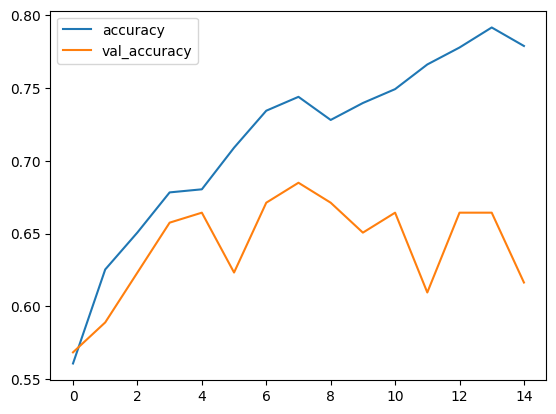

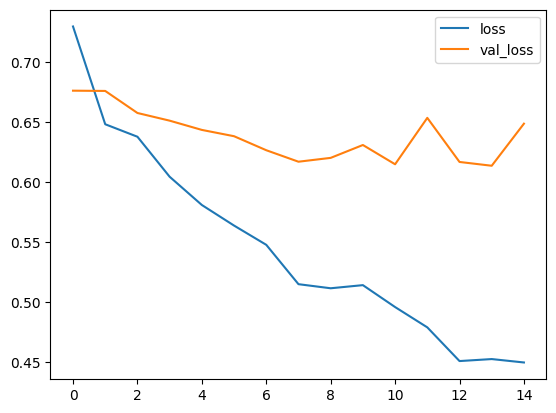

In [19]:
df = pd.DataFrame(history3.history)

df[['accuracy', 'val_accuracy']].plot()
df[['loss', 'val_loss']].plot()

# Modelo


In [7]:
datagen_resnet = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen_32 = datagen_resnet.flow_from_directory('DATASETS/Training-Mass/',
                            target_size=(224,224),
                            class_mode="categorical",
                            batch_size=32 
                            )


validation_gen_32 = datagen_resnet.flow_from_directory('DATASETS/Validation-Mass/',
                            target_size=(224,224),
                            class_mode="categorical",
                            batch_size=32
                            )

Found 945 images belonging to 2 classes.
Found 146 images belonging to 2 classes.


In [8]:
modelo_op = Sequential([ base_model,
                     GlobalAveragePooling2D(),
                     Dense(128, activation='relu'),
                     Dropout(0.2),
                     Dense(64, activation='relu'),
                     Dropout(0.2),
                     Dense(2, activation='Softmax')
])

modelo_op.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [9]:
modelo_op.compile(optimizer=Adam(learning_rate=1e-4),
               loss='categorical_crossentropy',
               metrics=['accuracy']
               )

history_op = modelo_op.fit(train_gen_32, 
           validation_data=validation_gen_32,
           epochs=15,
           batch_size=32,
           callbacks=[tensorBoard]
        )

Epoch 1/15
30/30 [==============================] - 11s 107ms/step - loss: 0.7826 - accuracy: 0.5513 - val_loss: 0.7033 - val_accuracy: 0.5342
Epoch 2/15
30/30 [==============================] - 2s 75ms/step - loss: 0.7023 - accuracy: 0.5841 - val_loss: 0.6717 - val_accuracy: 0.5685
Epoch 3/15
30/30 [==============================] - 2s 78ms/step - loss: 0.6649 - accuracy: 0.6180 - val_loss: 0.6552 - val_accuracy: 0.5548
Epoch 4/15
30/30 [==============================] - 2s 76ms/step - loss: 0.6449 - accuracy: 0.6392 - val_loss: 0.6446 - val_accuracy: 0.5822
Epoch 5/15
30/30 [==============================] - 2s 78ms/step - loss: 0.6189 - accuracy: 0.6455 - val_loss: 0.6437 - val_accuracy: 0.6096
Epoch 6/15
30/30 [==============================] - 2s 76ms/step - loss: 0.5989 - accuracy: 0.6868 - val_loss: 0.6443 - val_accuracy: 0.6301
Epoch 7/15
30/30 [==============================] - 2s 79ms/step - loss: 0.5678 - accuracy: 0.7016 - val_loss: 0.6551 - val_accuracy: 0.5822
Epoch 8/15


<Axes: >

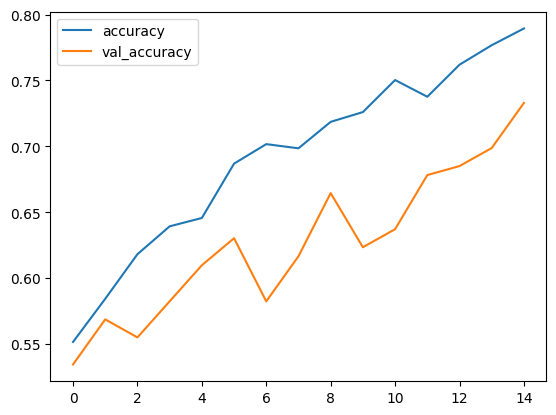

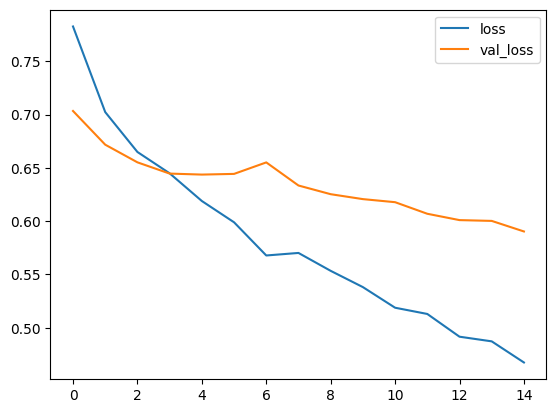

In [10]:
# salvando o modelo
modelo_op.save('models/best_model_epoch.h5')

# plotanco curva ROC
df = pd.DataFrame(history_op.history)
df[['accuracy', 'val_accuracy']].plot()
df[['loss', 'val_loss']].plot()

# Avaliando modelo utilizando a base de testes

In [98]:
# carregando o modelo
modelo_op = tf.keras.models.load_model('models/best_model_epoch.h5')
predictions = modelo_op.predict(test_gen, verbose=1)


29/29 [==============================] - 7s 239ms/step


### Confusuion matrix

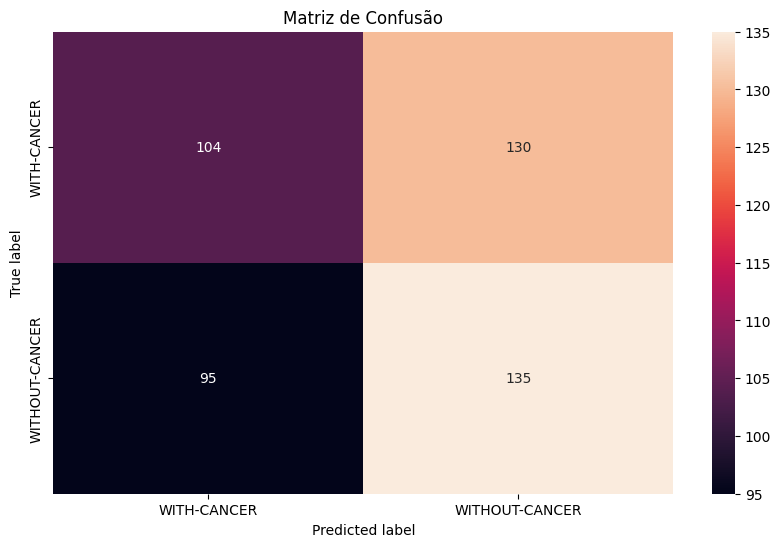

Verdadeiro Positivo (TP): 135
Verdadeiro Negativo (TN): 104
Falso Positivo (FP): 130
Falso Negativo (FN): 95


,WITH-CANCER,WITHOUT-CANCER
WITH-CANCER,104,130
WITHOUT-CANCER,95,135


                WITH-CANCER  WITHOUT-CANCER
WITH-CANCER             104             130
WITHOUT-CANCER           95             135


In [105]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Obtenha as labels automaticamente
class_labels = list(test_gen.class_indices.keys())

# Construa o DataFrame para o seaborn
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

plt.figure(figsize=(10, 6))
sns.heatmap(cm_df, annot=True, fmt='d')  # fmt='d' para números inteiros
plt.title('Matriz de Confusão')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


TP = cm[1, 1]  # Verdadeiro Positivo
TN = cm[0, 0]  # Verdadeiro Negativo
FP = cm[0, 1]  # Falso Positivo
FN = cm[1, 0]  # Falso Negativo

print(f"Verdadeiro Positivo (TP): {TP}")
print(f"Verdadeiro Negativo (TN): {TN}")
print(f"Falso Positivo (FP): {FP}")
print(f"Falso Negativo (FN): {FN}")

display(cm_df)
print(cm_df)

### Score 

In [116]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
classes_name = ('cancer', 'sem cancer')
height, width = (224, 224)


test_set = test_gen
test_set.reset()
y_pred = np.argmax(predictions, axis=-1)

y_test = test_gen.labels
cm = confusion_matrix(y_test,y_pred)



cm2 = classification_report(test_gen.classes, y_pred)

print(classification_report(test_gen.classes, y_pred))


file = open('time_bin_metrics.txt', 'w')
file.write('tempo %s' % cm2)
file.close()

              precision    recall  f1-score   support

           0       0.52      0.44      0.48       234
           1       0.51      0.59      0.55       230

    accuracy                           0.52       464
   macro avg       0.52      0.52      0.51       464
weighted avg       0.52      0.52      0.51       464



### Hold out

In [110]:
# pegando o score do modelo
score = modelo_op.evaluate(test_gen, verbose=1)
print("SCORE:",score)

29/29 [==============================] - 1s 34ms/step - loss: 0.6012 - accuracy: 0.6875
SCORE: [0.6011894345283508, 0.6875]


# Testes com imagens

In [112]:
def predicao(modelo, path):
    image = Image.open(path)

# Redimensione a imagem
    resized_image = image.resize((224, 224))

    # Certifique-se de que a imagem seja colorida (3 canais)
    if resized_image.mode == 'L':
        # Converta a imagem em escala de cinza em uma imagem RGB (colorida)
        resized_image = resized_image.convert('RGB')

    # Converta a imagem redimensionada em uma matriz NumPy
    np_array = np.array(resized_image)

    
    img_np = preprocess_input(np_array)
    imp_np2=img_np.reshape(1,224,224,3)
    result = modelo_op.predict(imp_np2)
    id_max= result[0].argmax()
    index_to_class = {v: k for k, v in train_gen_32.class_indices.items()}
    plt.title(f'Resultado: {index_to_class[id_max]}')
    plt.imshow(resized_image)
    plt.show()

1/1 [==============================] - 1s 572ms/step


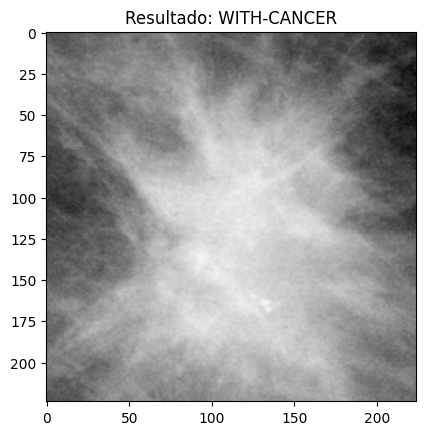

In [113]:
predicao(modelo_op, 'DATASETS/TESTING/WITH-CANCER/2-005.jpg')

1/1 [==============================] - 0s 22ms/step


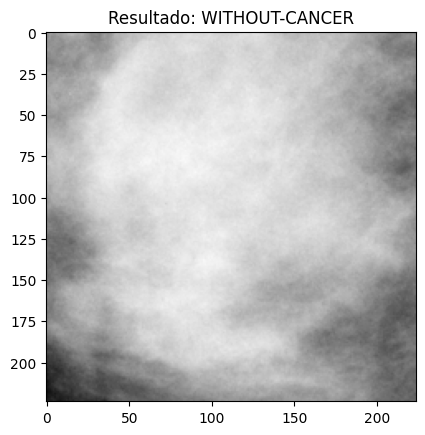

In [114]:
predicao(modelo_op, 'DATASETS/TESTING/WITHOUT-CANCER/1-271 (1).jpg')

DATASETS/TESTING\WITHOUT-CANCER\2-202.jpg
1/1 [==============================] - 0s 23ms/step


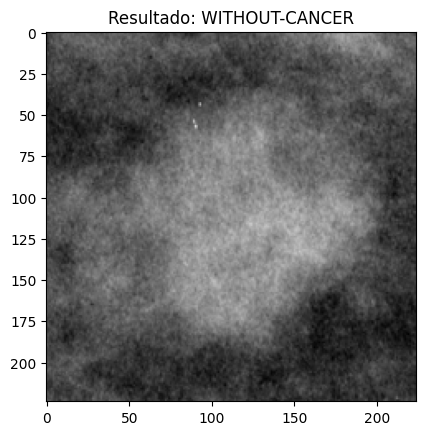

DATASETS/TESTING\WITHOUT-CANCER\2-086.jpg
1/1 [==============================] - 0s 22ms/step


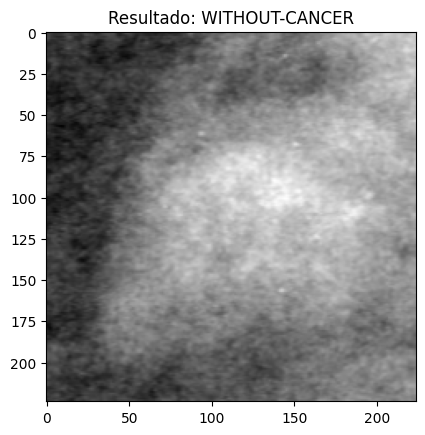

DATASETS/TESTING\WITHOUT-CANCER\1-277 (1).jpg
1/1 [==============================] - 0s 21ms/step


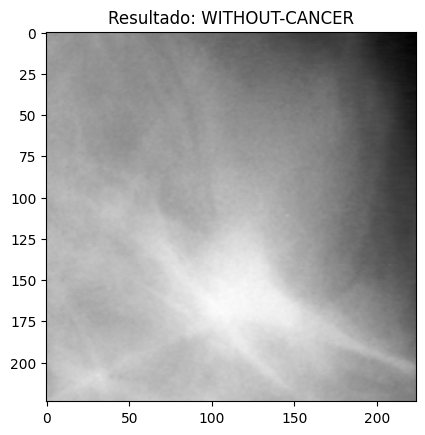

DATASETS/TESTING\WITHOUT-CANCER\2-010.jpg
1/1 [==============================] - 0s 20ms/step


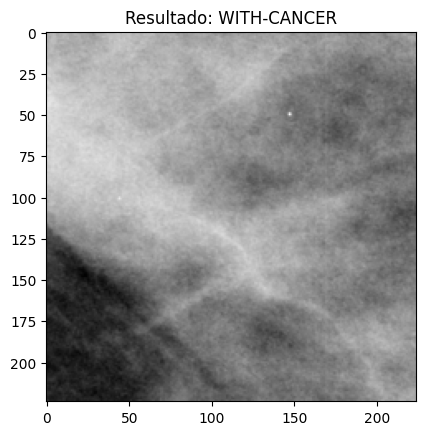

DATASETS/TESTING\WITHOUT-CANCER\2-171 (3).jpg
1/1 [==============================] - 0s 20ms/step


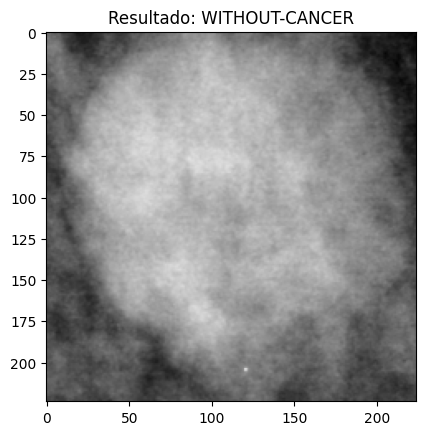

DATASETS/TESTING\WITH-CANCER\2-144 (1).jpg
1/1 [==============================] - 0s 20ms/step


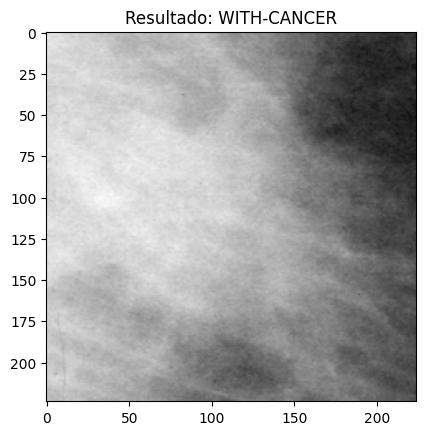

DATASETS/TESTING\WITH-CANCER\2-183.jpg
1/1 [==============================] - 0s 22ms/step


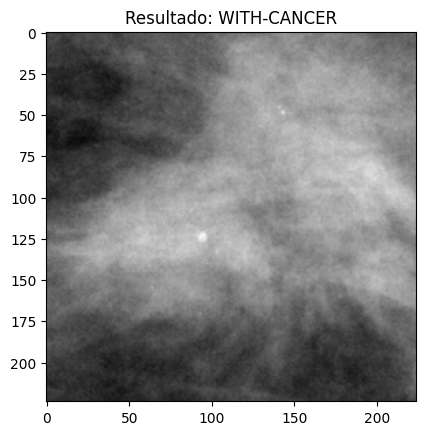

DATASETS/TESTING\WITHOUT-CANCER\2-140.jpg
1/1 [==============================] - 0s 31ms/step


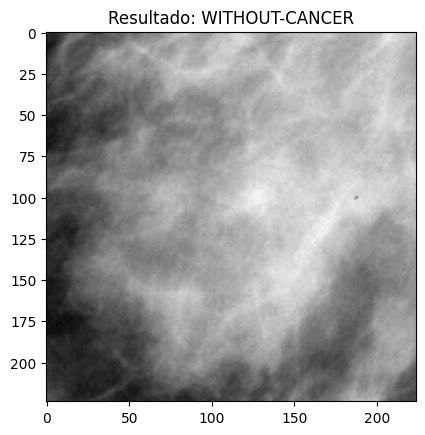

In [115]:

# pegando 10 cminhos aliatorios para predição e moreando o resultado
all_test_paths = glob.glob('DATASETS/TESTING/*/*.jpg')
for i in range(8):
    img_path=random.choice(all_test_paths)
    print(img_path)
    predicao(modelo_op, img_path)